In [1]:
#!/usr/bin/python3
# coding: utf-8
# prefectures

In [2]:
import codecs
from datetime import datetime as dt
from datetime import timedelta as td
import json
import matplotlib
import numpy as np
import os
import pandas as pd
from PIL import Image
import sys
if "ipy" not in sys.argv[0]:
    matplotlib.use('Agg')
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import plotly
import plotly.express as px
import plotly.tools as tls
import plotly.graph_objects as go
import plotly.io as pio
import plotly.offline as offline
from plotly.subplots import make_subplots
if "ipy" in sys.argv[0]:
    offline.init_notebook_mode()
from sklearn.neighbors import LocalOutlierFactor
from cov19utils import create_basic_plot_figure, \
    show_and_clear, moving_average, \
    blank2zero, csv2array, \
    get_twitter, tweet_with_image, \
    get_gpr_predict, FONT_NAME, DT_OFFSET, \
    download_if_needed, json2nparr, code2int, age2int, \
    get_populations, get_os_idx_of_arr, dump_val_in_arr, \
    calc_last1w2w_dif, create_basic_scatter_figure, \
    show_and_save_plotly

In [3]:
populations = get_populations()
#print(populations)

All population in Japan: 127094745


In [4]:
# 全国情報
ogiwara_uri = "https://raw.githubusercontent.com/kaz-ogiwara/covid19/master/data/"
pref_file = "prefectures.csv"
download_if_needed(ogiwara_uri, pref_file)

In [5]:
offsets = dict(
    year  = 0, # 年
    month = 1, # 月
    day   = 2, # 日
    st_ja = 3, # 都道府県
    st_en = 4, # state
    posis = 5, # 陽性者数
    tests = 6, # 検査数
    hospi = 7, # hospitalized
    serio = 8, # serious
    disch = 9, # discharged
    death =10, # deaths
    ern   =11, # Effective Reproduction Number
)

In [6]:
dt_start = dt.strptime("2020/2/8", "%Y/%m/%d") # 統計開始日
dt_now   = dt.now() # 現在日時
dt_delta = (dt_now - dt_start).days # 差分
n_states = 47 # 都道府県数
erns = [] # 実効再生産数
poss = [] # 陽性者数
test = [] # 検査数
for i in np.arange(dt_delta):
    erns.append(np.zeros(n_states+1).tolist())
    poss.append(np.zeros(n_states+1).tolist())
    test.append(np.zeros(n_states+1).tolist())
    test[i][0] = poss[i][0] = erns[i][0] = i

In [7]:
with codecs.open("prefectures.csv", encoding='utf-8') as f:
    l = f.readline()
    cnt = 0
    while l:
        l = f.readline().replace("\r\n", "").rstrip()
        elems = l.split(',')
        if len(elems) < 2:
            continue
        dt_idx  = (dt(int(elems[0]), int(elems[1]), int(elems[2])) - dt_start).days
        st_name = elems[offsets['st_en']]
        st_idx  = populations[st_name]['code']
        erns[dt_idx][st_idx] = blank2zero(elems[offsets['ern']])
        poss[dt_idx][st_idx] = blank2zero(elems[offsets['posis']])
        tested = blank2zero(elems[offsets['tests']])
        if tested > 0:
            test[dt_idx][st_idx] = tested
        cnt += 1
print("Load {} lines.".format(cnt))

Load 10712 lines.


In [8]:
erns = np.array(erns)
poss = np.array(poss)
test = np.array(test)

In [9]:
os_idx = get_os_idx_of_arr(erns, dt_delta)
latest_erns = erns[os_idx] # 最新の実効再生産数
dump_val_in_arr(populations, latest_erns, "最新の実効再生産数")

Data offset index: -2
最新の実効再生産数: 北海道=1.1 青森=3.0 岩手=1.0 宮城=0.8 秋田=1.6 山形=0.6 福島=1.0 茨城=0.8 栃木=1.6 群馬=1.9 埼玉=0.9 千葉=1.0 東京=0.9 神奈川=1.0 新潟=0.0 富山=0.0 石川=1.0 福井=4.0 山梨=1.0 長野=2.2 岐阜=1.8 静岡=1.6 愛知=1.2 三重=0.8 滋賀=1.2 京都=0.6 大阪=1.1 兵庫=0.9 奈良=0.8 和歌山=1.1 鳥取=0.0 島根=0.0 岡山=2.4 広島=0.4 山口=1.0 徳島=0.0 香川=1.2 愛媛=0.0 高知=0.0 福岡=0.7 佐賀=2.7 長崎=0.5 熊本=0.5 大分=0.0 宮崎=0.0 鹿児島=0.8 沖縄=1.4 


In [10]:
os_idx = get_os_idx_of_arr(poss, dt_delta)
latest_poss = poss[os_idx] # 最新の感染者数
dump_val_in_arr(populations, latest_poss, "最新の感染者数", 0)

Data offset index: -2
最新の感染者数: 北海道=2612 青森=148 岩手=26 宮城=544 秋田=61 山形=82 福島=378 茨城=735 栃木=473 群馬=820 埼玉=5521 千葉=4680 東京=29520 神奈川=8155 新潟=180 富山=422 石川=796 福井=256 山梨=202 長野=329 岐阜=660 静岡=585 愛知=5749 三重=551 滋賀=533 京都=1945 大阪=11780 兵庫=3040 奈良=621 和歌山=266 鳥取=35 島根=140 岡山=188 広島=651 山口=211 徳島=164 香川=100 愛媛=116 高知=140 福岡=5160 佐賀=253 長崎=242 熊本=759 大分=159 宮崎=366 鹿児島=463 沖縄=3048 


In [11]:
diff1w_poss, diff2w_poss = calc_last1w2w_dif(poss, dt_delta)
dump_val_in_arr(populations, diff1w_poss, "1週間陽性者数", 0)
dump_val_in_arr(populations, diff2w_poss, "2週間陽性者数", 0)

Data offset index: -2
1週間陽性者数: 北海道=182 青森=91 岩手=1 宮城=40 秋田=2 山形=1 福島=46 茨城=16 栃木=20 群馬=56 埼玉=287 千葉=250 東京=1103 神奈川=397 新潟=0 富山=0 石川=9 福井=7 山梨=3 長野=9 岐阜=20 静岡=13 愛知=153 三重=7 滋賀=13 京都=47 大阪=419 兵庫=94 奈良=14 和歌山=12 鳥取=-1 島根=0 岡山=20 広島=7 山口=2 徳島=15 香川=4 愛媛=1 高知=0 福岡=35 佐賀=4 長崎=1 熊本=33 大分=1 宮崎=0 鹿児島=7 沖縄=222 
2週間陽性者数: 北海道=345 青森=111 岩手=2 宮城=91 秋田=3 山形=3 福島=91 茨城=37 栃木=30 群馬=79 埼玉=598 千葉=487 東京=2405 神奈川=824 新潟=4 富山=0 石川=18 福井=8 山梨=6 長野=12 岐阜=29 静岡=20 愛知=271 三重=16 滋賀=23 京都=145 大阪=781 兵庫=202 奈良=34 和歌山=23 鳥取=-1 島根=0 岡山=26 広島=36 山口=4 徳島=15 香川=7 愛媛=1 高知=2 福岡=91 佐賀=5 長崎=4 熊本=117 大分=1 宮崎=22 鹿児島=16 沖縄=366 


In [12]:
# 都道府県別 罹患率
incid1w_rate = np.zeros(n_states + 1).tolist() # 罹患率 (1週足)
incid2w_rate = np.zeros(n_states + 1).tolist() # 罹患率 (2週足)
incid_all_rate = np.zeros(n_states + 1).tolist() # 罹患率 (全期間)
for k, v in populations.items():
    i = v['code']
    incid1w_rate[i] = (diff1w_poss[i] / v['total']) * 100 # percentage
    incid2w_rate[i] = (diff2w_poss[i] / v['total']) * 100 # percentage
    incid_all_rate[i] = (latest_poss[i] / v['total']) * 100 # percentage
dump_val_in_arr(populations, incid_all_rate, "全期間罹患率", 3)

全期間罹患率: 北海道=0.049 青森=0.011 岩手=0.002 宮城=0.023 秋田=0.006 山形=0.007 福島=0.020 茨城=0.025 栃木=0.024 群馬=0.042 埼玉=0.076 千葉=0.075 東京=0.218 神奈川=0.089 新潟=0.008 富山=0.040 石川=0.069 福井=0.033 山梨=0.024 長野=0.016 岐阜=0.032 静岡=0.016 愛知=0.077 三重=0.030 滋賀=0.038 京都=0.075 大阪=0.133 兵庫=0.055 奈良=0.046 和歌山=0.028 鳥取=0.006 島根=0.020 岡山=0.010 広島=0.023 山口=0.015 徳島=0.022 香川=0.010 愛媛=0.008 高知=0.019 福岡=0.101 佐賀=0.030 長崎=0.018 熊本=0.042 大分=0.014 宮崎=0.033 鹿児島=0.028 沖縄=0.213 


In [13]:
diff1w_test, diff2w_test = calc_last1w2w_dif(test, dt_delta)
dump_val_in_arr(populations, diff1w_test, "1週間陽検査数", 0)
dump_val_in_arr(populations, diff2w_test, "2週間陽検査数", 0)

Data offset index: -2
1週間陽検査数: 北海道=4992 青森=623 岩手=241 宮城=650 秋田=60 山形=374 福島=2473 茨城=387 栃木=923 群馬=1293 埼玉=11138 千葉=8190 東京=23463 神奈川=8451 新潟=491 富山=410 石川=805 福井=404 山梨=199 長野=1038 岐阜=804 静岡=1683 愛知=4681 三重=598 滋賀=332 京都=2478 大阪=11572 兵庫=2525 奈良=712 和歌山=213 鳥取=26 島根=95 岡山=0 広島=1483 山口=519 徳島=194 香川=758 愛媛=69 高知=29 福岡=7018 佐賀=451 長崎=789 熊本=615 大分=954 宮崎=37 鹿児島=426 沖縄=3885 
2週間陽検査数: 北海道=10476 青森=926 岩手=519 宮城=1496 秋田=110 山形=447 福島=4549 茨城=662 栃木=2082 群馬=3052 埼玉=20896 千葉=14634 東京=55484 神奈川=20122 新潟=1117 富山=1059 石川=1791 福井=716 山梨=410 長野=1832 岐阜=1662 静岡=3503 愛知=9143 三重=1236 滋賀=948 京都=5006 大阪=22502 兵庫=5412 奈良=1860 和歌山=521 鳥取=59 島根=179 岡山=0 広島=4725 山口=977 徳島=270 香川=1472 愛媛=117 高知=70 福岡=14372 佐賀=577 長崎=1742 熊本=1686 大分=1946 宮崎=82 鹿児島=1546 沖縄=7161 


In [14]:
# 都道府県別 陽性率
test1w_rate = np.zeros(n_states + 1).tolist() # 陽性率 (1週足)
test2w_rate = np.zeros(n_states + 1).tolist() # 陽性率 (2週足)
for k, v in populations.items():
    i = v['code']
    if diff1w_test[i] > 0:
        test1w_rate[i] = (diff1w_poss[i] / diff1w_test[i]) * 100 # percentage
    if diff2w_test[i] > 0:
        test2w_rate[i] = (diff2w_poss[i] / diff2w_test[i]) * 100 # percentage
dump_val_in_arr(populations, test1w_rate, "1週間陽性率", 1)
dump_val_in_arr(populations, test2w_rate, "2週間陽性率", 1)

1週間陽性率: 北海道=3.6 青森=14.6 岩手=0.4 宮城=6.2 秋田=3.3 山形=0.3 福島=1.9 茨城=4.1 栃木=2.2 群馬=4.3 埼玉=2.6 千葉=3.1 東京=4.7 神奈川=4.7 新潟=0.0 富山=0.0 石川=1.1 福井=1.7 山梨=1.5 長野=0.9 岐阜=2.5 静岡=0.8 愛知=3.3 三重=1.2 滋賀=3.9 京都=1.9 大阪=3.6 兵庫=3.7 奈良=2.0 和歌山=5.6 鳥取=-3.8 島根=0.0 岡山=0.0 広島=0.5 山口=0.4 徳島=7.7 香川=0.5 愛媛=1.4 高知=0.0 福岡=0.5 佐賀=0.9 長崎=0.1 熊本=5.4 大分=0.1 宮崎=0.0 鹿児島=1.6 沖縄=5.7 
2週間陽性率: 北海道=3.3 青森=12.0 岩手=0.4 宮城=6.1 秋田=2.7 山形=0.7 福島=2.0 茨城=5.6 栃木=1.4 群馬=2.6 埼玉=2.9 千葉=3.3 東京=4.3 神奈川=4.1 新潟=0.4 富山=0.0 石川=1.0 福井=1.1 山梨=1.5 長野=0.7 岐阜=1.7 静岡=0.6 愛知=3.0 三重=1.3 滋賀=2.4 京都=2.9 大阪=3.5 兵庫=3.7 奈良=1.8 和歌山=4.4 鳥取=-1.7 島根=0.0 岡山=0.0 広島=0.8 山口=0.4 徳島=5.6 香川=0.5 愛媛=0.9 高知=2.9 福岡=0.6 佐賀=0.9 長崎=0.2 熊本=6.9 大分=0.1 宮崎=26.8 鹿児島=1.0 沖縄=5.1 


In [15]:
if False:
    fig, ax = create_basic_scatter_figure("実効再生産数(感染拡大しているか？)", "直近1週間罹患率(県内で自分が罹患する確率)[%]")
    cols = [ "#ff0000" for i in range(n_states)]
    texts = [ "?" for i in range(n_states)]
    for k, v in populations.items():
        cols[v['code'] - 1]  = cm.hsv(v['region'] / 11)
        texts[v['code'] - 1] = v['ja']
    plt.scatter(latest_erns[1:], incid1w_rate[1:], s=50, c=cols)
    for i in range(n_states):
        ax.annotate(texts[i], xy=(latest_erns[1 + i], incid1w_rate[1 + i]), size=15, fontname=FONT_NAME)
    tw_body_1w = '全国 新型コロナ情報 都道府県別拡大傾向(直近1週間)'
    plt.title(tw_body_1w, fontname=FONT_NAME)
    show_and_clear(fig, "docs/images/ern-1w_poss.jpg")

In [16]:
fig = go.Figure()
cols = [ "#ff0000" for i in range(n_states)]
texts = [ "?" for i in range(n_states)]

for k, v in populations.items():
    cols[v['code'] - 1]  = "hsv({},100%,100%)".format(int((v['region'] * 255) / 11))
    texts[v['code'] - 1] = v['ja']

fig.add_trace(go.Scatter(x=latest_erns[1:], y=incid1w_rate[1:],
                         mode='markers+text', marker=dict(size=9, color=cols),
                         text=texts, textposition='top center'))
tw_body_1w = '全国 新型コロナ情報 都道府県別拡大傾向(直近1週間)'
fig.update_layout(
    title=tw_body_1w,
    xaxis=dict(title="実効再生産数(感染拡大しているか？)"),
    yaxis=dict(title="直近1週間罹患率(県内で自分が罹患する確率)[%]")
)
show_and_save_plotly(fig, "ern-1w_poss.jpg", js=False)

wrote to docs/images/ern-1w_poss.jpg
wrote to docs/_includes/ern-1w_poss.html


In [17]:
def show_zoomed_ern_scatter(
    xbins, ybins, colors, xytexts, nweek, filename, title, xlabel, ylabel,
    n_neighbors=30, n_states=47):
    fig, ax = create_basic_scatter_figure(xlabel, ylabel)
    # LOF
    clf = LocalOutlierFactor(
        n_neighbors=n_neighbors, contamination='auto',
        algorithm='auto', metric='mahalanobis')
    X = np.stack([xbins[1:], ybins[1:]], 1)
    y_pred = clf.fit_predict(X)
    selected_cols = np.array(colors)[y_pred == 1]
    selected_text = np.array(xytexts)[y_pred == 1]
    # append top element
    y_pred = np.append(-1, y_pred)
    selected_xbins = xbins[y_pred == 1]
    selected_ybins = np.array(ybins)[y_pred == 1]
    plt.xlim(0, np.max(selected_xbins))
    plt.ylim(0, np.max(selected_ybins))
    plt.scatter(selected_xbins, selected_ybins, s=50, c=selected_cols)
    for i in np.arange(len(selected_xbins)):
        ax.annotate(selected_text[i], xy=(selected_xbins[i], selected_ybins[i]), size=15, fontname=FONT_NAME)
    plt.title(title, fontname=FONT_NAME)
    show_and_clear(fig, filename)

In [18]:
def show_zoomed_ern_plotly(
    xbins, ybins, colors, xytexts, nweek, filename, title, xlabel, ylabel,
    n_neighbors=30, n_states=47):
    fig = go.Figure()
    # LOF
    clf = LocalOutlierFactor(n_neighbors=n_neighbors, contamination='auto', algorithm='auto', metric='mahalanobis')
    X = np.stack([xbins[1:], ybins[1:]], 1)
    y_pred = clf.fit_predict(X)
    selected_cols = np.array(colors)[y_pred == 1]
    selected_text = np.array(xytexts)[y_pred == 1]
    # append top element
    y_pred = np.append(-1, y_pred)
    selected_xbins = xbins[y_pred == 1]
    selected_ybins = np.array(ybins)[y_pred == 1]
    fig.add_trace(go.Scatter(x=selected_xbins, y=selected_ybins,
                         mode='markers+text', marker=dict(size=9, color=selected_cols),
                         text=selected_text, textposition='top center'))
    fig.update_layout(title=title, xaxis=dict(title=xlabel), yaxis=dict(title=ylabel))
    show_and_save_plotly(fig, filename, js=False)

In [19]:
tw_body_1w_zoom = '全国 新型コロナ情報 都道府県別拡大傾向(直近1週間)ズーム表示'
show_zoomed_ern_plotly(
    latest_erns, incid1w_rate, cols, texts, 1, "ern-1w_poss-zoom.jpg",
    tw_body_1w_zoom,
    "実効再生産数(感染拡大しているか？)",
    "直近1週間罹患率(県内で自分が罹患する確率)[%]")

wrote to docs/images/ern-1w_poss-zoom.jpg
wrote to docs/_includes/ern-1w_poss-zoom.html


In [20]:
if False:
    pfig, ax = create_basic_scatter_figure("実効再生産数(感染拡大しているか？)", "直近2週間罹患率(県内で自分が罹患する確率)[%]")
    plt.scatter(latest_erns[1:], incid2w_rate[1:], s=50, c=cols)
    tw_body_2w = '全国 新型コロナ情報 都道府県別拡大傾向(直近2週間)'
    plt.title(tw_body_2w, fontname=FONT_NAME)
    for i in range(n_states):
        ax.annotate(texts[i], xy=(latest_erns[1 + i], incid2w_rate[1 + i]), size=15, fontname=FONT_NAME)
    show_and_clear(fig, "docs/images/ern-2w_poss.jpg")

In [21]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=latest_erns[1:], y=incid2w_rate[1:],
                         mode='markers+text', marker=dict(size=9, color=cols),
                         text=texts, textposition='top center'))
tw_body_2w = '全国 新型コロナ情報 都道府県別拡大傾向(直近2週間)'
fig.update_layout(
    title=tw_body_2w,
    xaxis=dict(title="実効再生産数(感染拡大しているか？)"),
    yaxis=dict(title="直近2週間罹患率(県内で自分が罹患する確率)[%]"))
show_and_save_plotly(fig, "ern-2w_poss.jpg", js=False)

wrote to docs/images/ern-2w_poss.jpg
wrote to docs/_includes/ern-2w_poss.html


In [22]:
tw_body_2w_zoom = '全国 新型コロナ情報 都道府県別拡大傾向(直近2週間)ズーム表示'
show_zoomed_ern_plotly(
    latest_erns, incid2w_rate, cols, texts, 2, "ern-2w_poss-zoom.jpg",
    tw_body_2w_zoom,
    "実効再生産数(感染拡大しているか？)",
    "直近2週間罹患率(県内で自分が罹患する確率)[%]")

wrote to docs/images/ern-2w_poss-zoom.jpg
wrote to docs/_includes/ern-2w_poss-zoom.html


In [23]:
from japanmap import picture
def make_japan_heatmap(filename, title, npa1d, populations):
    """ 都道府県別ヒートマップを表示する """
    fig = go.Figure()
    w = 610
    h = 630
    cmap = plt.get_cmap("rainbow")
    norm = plt.Normalize(vmin=np.min(npa1d[1:]), vmax=np.max(npa1d[1:]))
    fcol = lambda x: '#' + bytes(cmap(norm(x), bytes=True)[:3]).hex()
    fig.add_trace(go.Scatter(x=[0, w], y=[0, h], mode='markers', marker_opacity=0))
    fig.add_trace(go.Heatmap(x=[0, 0], y=[0, 0], opacity=0,
        z=[np.min(npa1d[1:]), np.max(npa1d[1:])],
        zmin=np.min(npa1d[1:]), zmax=np.max(npa1d[1:]),
        type='heatmap', colorscale='Rainbow', showscale=True))
    map_cols = {}
    for k, v in populations.items():
        map_cols[v['ja']] = fcol(npa1d[v['code']])
    pict = picture(map_cols)
    axis_template = lambda x: dict(
        range=[0, x], autorange=False, showgrid=False, zeroline=False,
        linecolor='black', showticklabels=False, ticks='')
    fig.update_layout(title=title, xaxis=axis_template(w), yaxis=axis_template(h),
                     showlegend=False, width=w, height=h, autosize=False,
                      margin={"l": 0, "r": 0, "t":40, "b": 0}
                     )
    fig.add_layout_image(dict(
            x=0, sizex=w, y=h, sizey=h, xref="x", yref="y", opacity=1,
            layer="below", sizing="stretch", source=Image.fromarray(pict)))
    show_and_save_plotly(fig, filename, js=False, show=True, image=True, html=False)

In [24]:
def make_japan_choropleth(filename, title, npa1d):
    """ 日本の choropleth を作成する """
    f = codecs.open("japan-min.geojson", "r", encoding='utf-8')
    geojson = json.load(f)
    f.close()
    df = pd.read_csv('population.txt',
                     header=None, names=['reg', 'code', 'name', 'en', 'total', 'color'],
                     dtype={'reg':int, 'code':int, 'name':str, 'total':int, 'color':float})
    for i in range(len(npa1d)):
        df.loc[i, 'color'] = npa1d[i]
        #print(i, df.loc[i, 'color'], df.loc[i, 'name'], npa1d[i])
        i += 1
    fig = px.choropleth(df, geojson=geojson, color="color", hover_name='name',
                    locations="code", featureidkey="properties.id",
                    labels={'color':'値', 'code':'都道府県コード'},
                    projection="mercator", title=title)
    fig.update_geos(visible=False,
                    lonaxis=dict(range=[127.632493, 145.792893]),
                    lataxis=dict(range=[26.089333, 45.531737]))
    fig.update_layout(margin={"r":0,"t":40,"l":0,"b":0})
    show_and_save_plotly(fig, filename, js=False, show=False, image=False, html=True)

wrote to docs/_includes/japan-erns.html



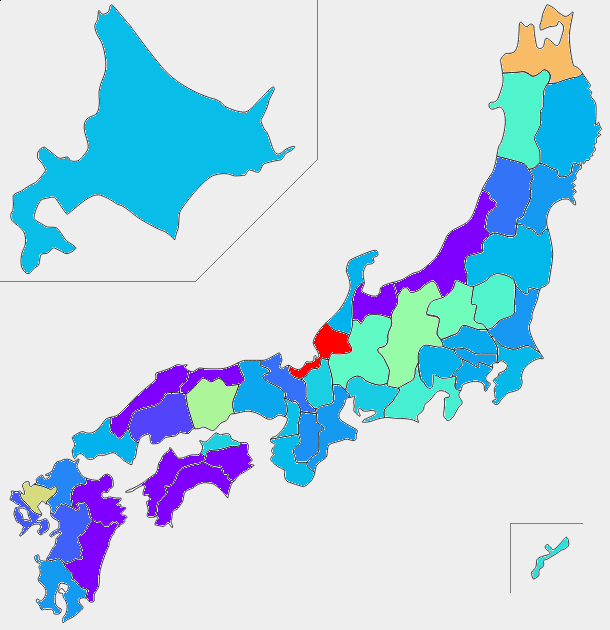

wrote to docs/images/japan-erns.jpg


In [25]:
tw_body_map_erns = "全国 新型コロナ情報 都道府県別 実効再生産数"
imgname = 'japan-erns.jpg'
make_japan_choropleth(imgname, tw_body_map_erns, latest_erns[1:])
make_japan_heatmap(imgname, tw_body_map_erns, latest_erns, populations)

In [26]:
#tw_body_map_erns = "全国 新型コロナ情報 都道府県別 実効再生産数"
#mak_japan_heatmap('docs/images/japan-erns.jpg', tw_body_map_erns, latest_erns, populations)

wrote to docs/_includes/japan-1w.html



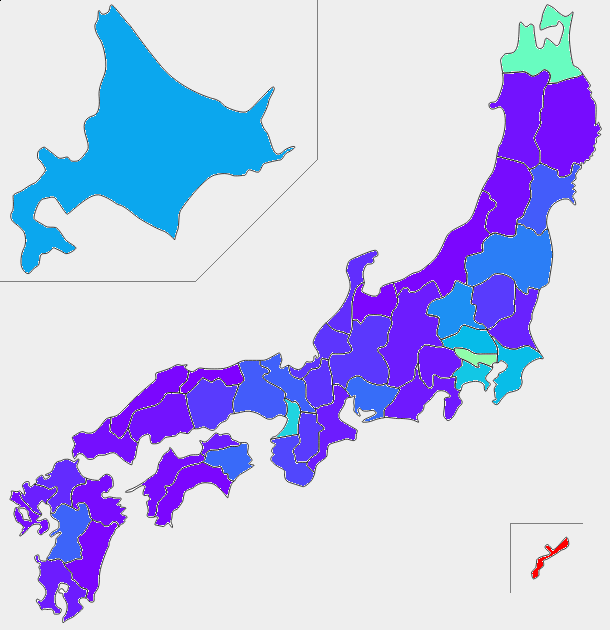

wrote to docs/images/japan-1w.jpg


In [27]:
tw_body_map_1w = "全国 新型コロナ情報 都道府県別 直近1週間罹患率"
imgname = 'japan-1w.jpg'
make_japan_choropleth(imgname, tw_body_map_1w, incid1w_rate[1:])
make_japan_heatmap(imgname, tw_body_map_1w, incid1w_rate, populations)

wrote to docs/_includes/japan-2w.html



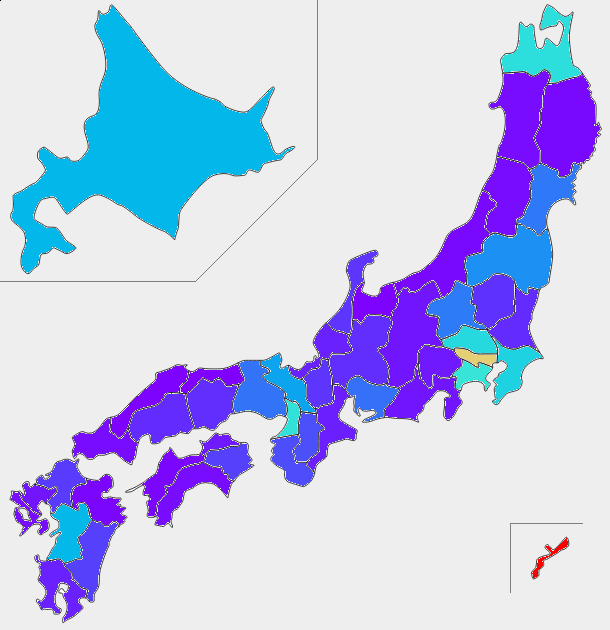

wrote to docs/images/japan-2w.jpg


In [28]:
tw_body_map_2w = "全国 新型コロナ情報 都道府県別 直近2週間罹患率"
imgname = 'japan-2w.jpg'
make_japan_choropleth(imgname, tw_body_map_2w, incid2w_rate[1:])
make_japan_heatmap(imgname, tw_body_map_2w, incid2w_rate, populations)

wrote to docs/_includes/japan-all.html



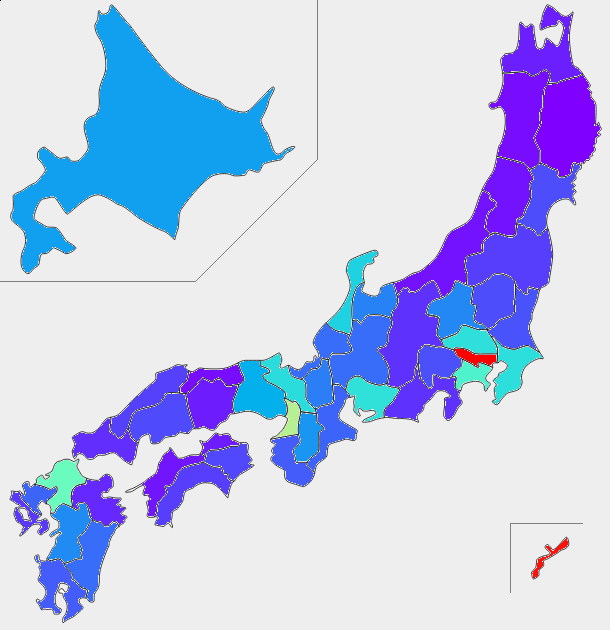

wrote to docs/images/japan-all.jpg


In [29]:
tw_body_map_all = "全国 新型コロナ情報 都道府県別 罹患率(全期間)"
imgname = 'japan-all.jpg'
make_japan_choropleth(imgname, tw_body_map_all, incid_all_rate[1:])
make_japan_heatmap(imgname, tw_body_map_all, incid_all_rate, populations)

wrote to docs/_includes/japan-rate1w.html



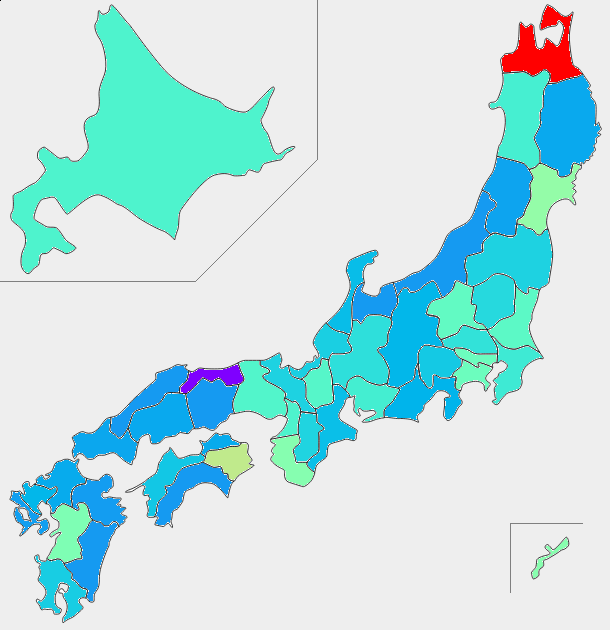

wrote to docs/images/japan-rate1w.jpg


In [30]:
tw_body_map_rate1w = "全国 新型コロナ情報 都道府県別 直近1週間陽性率"
imgname = 'japan-rate1w.jpg'
make_japan_choropleth(imgname, tw_body_map_rate1w, test1w_rate[1:])
make_japan_heatmap(imgname, tw_body_map_rate1w, test1w_rate, populations)

wrote to docs/_includes/japan-rate2w.html



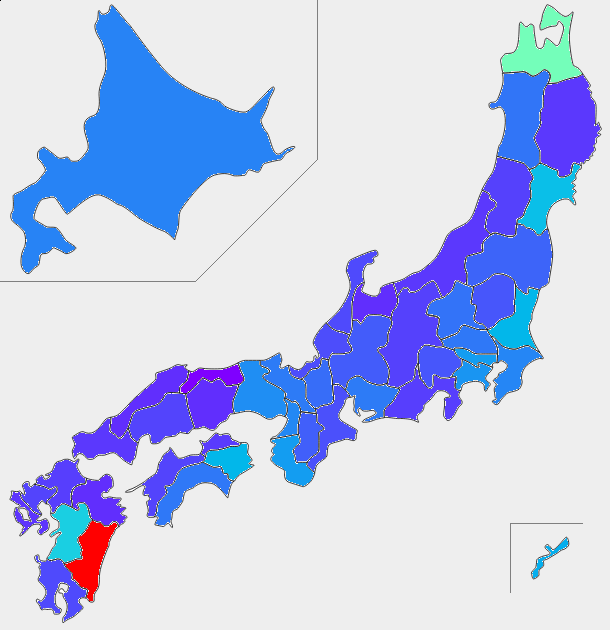

wrote to docs/images/japan-rate2w.jpg


In [31]:
tw_body_map_rate2w = "全国 新型コロナ情報 都道府県別 直近2週間陽性率"
imgname = 'japan-rate2w.jpg'
make_japan_choropleth(imgname, tw_body_map_rate2w, test2w_rate[1:])
make_japan_heatmap(imgname, tw_body_map_rate2w, test2w_rate, populations)

In [32]:
tw = get_twitter()
today_str = dt.now().isoformat()[:19].replace('T', ' ')
tw_body_postfix = " https://geneasyura.github.io/cov19-hm/pref.html (東洋経済 " + today_str + " 現在)"
#tweet_with_image(tw, "images/ern-1w_poss.jpg", tw_body_1w + tw_body_postfix)
#tweet_with_image(tw, "images/ern-1w_poss-zoom.jpg", tw_body_1w_zoom + tw_body_postfix)
tweet_with_image(tw, "docs/images/ern-2w_poss.jpg", tw_body_2w + tw_body_postfix)
tweet_with_image(tw, "docs/images/ern-2w_poss-zoom.jpg", tw_body_2w_zoom + tw_body_postfix)

In [33]:
tweet_with_image(tw, 'docs/images/japan-erns.jpg', tw_body_map_erns + tw_body_postfix)
#tweet_with_image(tw, 'images/japan-1w.jpg', tw_body_map_1w + tw_body_postfix)
tweet_with_image(tw, 'docs/images/japan-2w.jpg', tw_body_map_2w + tw_body_postfix)
tweet_with_image(tw, 'docs/images/japan-all.jpg', tw_body_map_all + tw_body_postfix)

In [34]:
tweet_with_image(tw, 'docs/images/japan-rate1w.jpg', tw_body_map_rate1w + tw_body_postfix)
tweet_with_image(tw, 'docs/images/japan-rate2w.jpg', tw_body_map_rate2w + tw_body_postfix)